# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [1]:
from sklearn.preprocessing import StandardScaler

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
import os
import numpy as np
import xarray as xr

In [28]:
os.getcwd()

'C:\\Users\\goyetc\\SOMPY'

In [4]:
import datetime

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [5]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
#DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [6]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [7]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [8]:
SOM_input.shape
#SOM_input.head()

(17290470, 7)

In [9]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [10]:
SOM_sample = SOM_input.sample(200000)
SOM_sample = SOM_sample.reset_index(drop=True)

In [11]:
#log(MLD)
SOM_sample[['MLD']] = SOM_sample[['MLD']].apply(np.log)

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [13]:
ss = StandardScaler().fit_transform(SOM_sample[['SSS','SST','MLD','pCO2']])

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
ss.shape

(200000L, 4L)

In [15]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for number of neurons
M = 5*np.sqrt(ss.shape[0])
M
#insert source

2236.0679774997898

In [16]:
m=int(np.sqrt(M))
m

47

### Notes on SOM tuning
* testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
* batch faster than sequential

mapsize = [4,4]
som = sompy.SOMFactory.build(ss, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', 
                             initialization='random', neighborhood='gaussian', 
                             training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=10, verbose='info',train_rough_len=20, train_finetune_len=20)  # verbose='debug' will print more, and verbose=None wont print anything
#sm.train(n_job=5, verbose='info', train_rough_len=20, train_finetune_len=50)

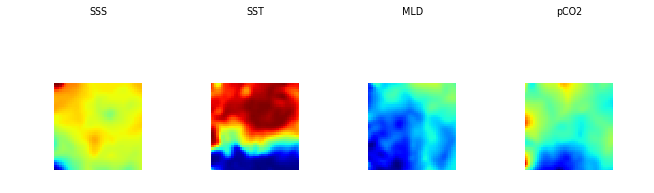

In [157]:
v = sompy.mapview.View2DPacked(40, 40, '',text_size=8)  
v.show(top_model_n20_r20_f40_pca_rect, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default

In [165]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(40,40, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl_5 = top_model_n20_r20_f40_pca_rect.cluster(n_clusters=5)
# print cl
getattr(top_model_n20_r20_f40_pca_rect, 'cluster_labels')

array([1, 3, 3, ..., 2, 2, 2])

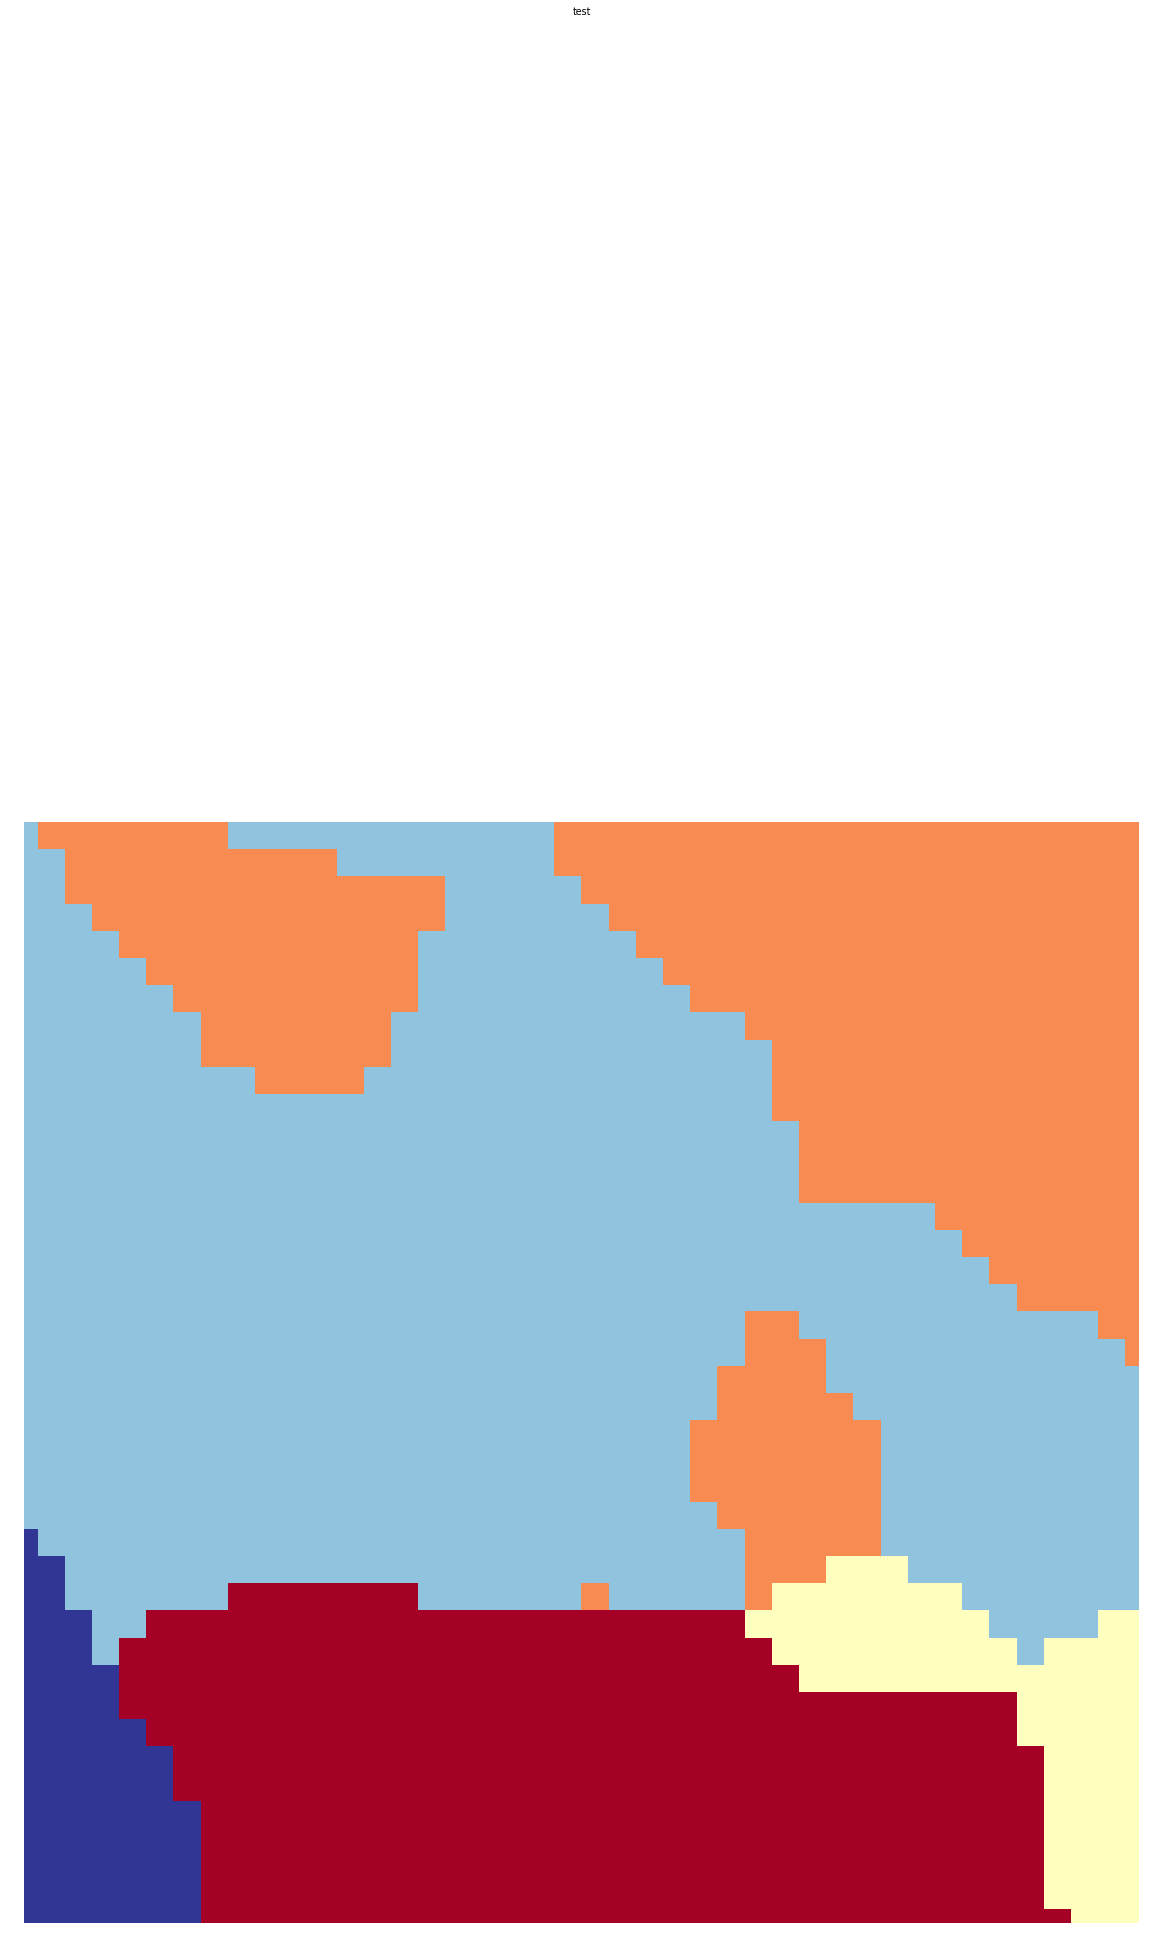

In [166]:
v.show(top_model_n20_r20_f40_pca_rect, what='cluster')

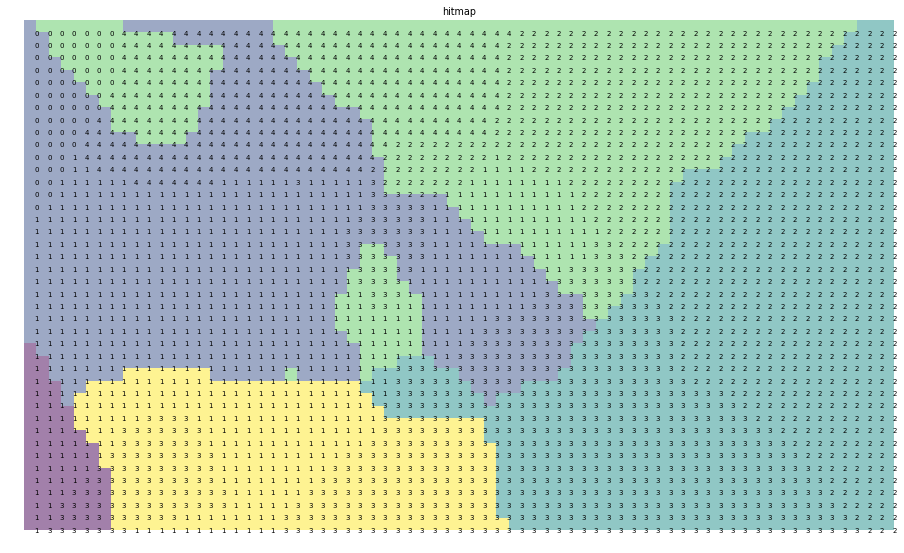

In [167]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(top_model_n20_r20_f40_pca_rect)

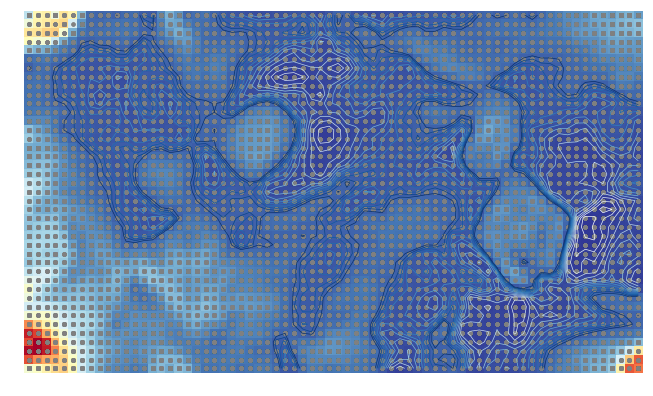

In [169]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(top_model_n20_r20_f40_pca_rect, distance=2, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(top_model_n20_r20_f40_pca_rect, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


# TO DO
* Interpret hitmap and u-matrix more.. pretty but what can be learned?
* Try with other combos, e.g., No Chl or log(MLD) per Landschutzer
* Perform tuning exercise to choose model with lowest error
* Validate conversion of SOM results back to cluster designation for raw data (e.g., translation of neuron results to all raw data points based on centroid/BMU value)
* Validate that "clustering" method described using k-means above, post model-build, is what we're looking for

In [170]:
%matplotlib inline
import math
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

In [171]:
import random

In [172]:
m,10*m,(9*m)**2

(47, 470, 178929)

In [179]:
names = ['SSS','SST','MLD','pCO2']

In [102]:
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study 
# 20 models built, evaluated for topographic error

for i in range(20): 
    sm = sompy.SOMFactory().build(ss, 
                            mapsize=[random.choice(list(range(m/3,2*m))), 
                                     random.choice(list(range(m/3,2*m)))], 
                            normalization = 'var', initialization='pca', 
                            component_names=names, lattice='rect') 
    sm.train(n_job=1, 
             verbose='info', 
             train_rough_len=20, 
             train_finetune_len=40) 
    
    joblib.dump(sm, "model_{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.250000 seconds
 Rough training...
 radius_ini: 11.000000 , radius_final: 2.750000, trainlen: 20

 epoch: 1 ---> elapsed time:  42.458000, quantization error: 0.969086

 epoch: 2 ---> elapsed time:  43.129000, quantization error: 0.820330

 epoch: 3 ---> elapsed time:  48.887000, quantization error: 0.749318

 epoch: 4 ---> elapsed time:  43.213000, quantization error: 0.702257

 epoch: 5 ---> elapsed time:  40.728000, quantization error: 0.666921

 epoch: 6 ---> elapsed time:  41.256000, quantization error: 0.639339

 epoch: 7 ---> elapsed time:  40.289000, quantization error: 0.617688

 epoch: 8 ---> elapsed time:  41.297000, quantization error: 0.598368

 epoch: 9 ---> elapsed time:  40.928000, quantization error: 0.579378

 epoch: 10 ---> elapsed time:  41.924000, quantization error: 0.560110

 epoch: 11 ---> elapsed time:  42.834000, quantization error: 0.540191

 epoch: 12 ---> elapsed time:  46.904000, quantization error: 0.519636



 epoch: 28 ---> elapsed time:  19.402000, quantization error: 0.296561

 epoch: 29 ---> elapsed time:  19.524000, quantization error: 0.292769

 epoch: 30 ---> elapsed time:  18.908000, quantization error: 0.288972

 epoch: 31 ---> elapsed time:  18.821000, quantization error: 0.285211

 epoch: 32 ---> elapsed time:  19.004000, quantization error: 0.281448

 epoch: 33 ---> elapsed time:  18.922000, quantization error: 0.277667

 epoch: 34 ---> elapsed time:  18.920000, quantization error: 0.273865

 epoch: 35 ---> elapsed time:  19.364000, quantization error: 0.270043

 epoch: 36 ---> elapsed time:  19.075000, quantization error: 0.266213

 epoch: 37 ---> elapsed time:  19.342000, quantization error: 0.262349

 epoch: 38 ---> elapsed time:  19.643000, quantization error: 0.258493

 epoch: 39 ---> elapsed time:  18.954000, quantization error: 0.254613

 epoch: 40 ---> elapsed time:  18.952000, quantization error: 0.250740

 Final quantization error: 0.250740
 train took: 1145.432000 sec

 epoch: 16 ---> elapsed time:  4.867000, quantization error: 0.436881

 epoch: 17 ---> elapsed time:  4.936000, quantization error: 0.431776

 epoch: 18 ---> elapsed time:  4.726000, quantization error: 0.426681

 epoch: 19 ---> elapsed time:  4.777000, quantization error: 0.421555

 epoch: 20 ---> elapsed time:  4.742000, quantization error: 0.416385

 epoch: 21 ---> elapsed time:  4.749000, quantization error: 0.411169

 epoch: 22 ---> elapsed time:  4.834000, quantization error: 0.405906

 epoch: 23 ---> elapsed time:  4.850000, quantization error: 0.400674

 epoch: 24 ---> elapsed time:  4.848000, quantization error: 0.395414

 epoch: 25 ---> elapsed time:  4.911000, quantization error: 0.390176

 epoch: 26 ---> elapsed time:  4.961000, quantization error: 0.384940

 epoch: 27 ---> elapsed time:  4.886000, quantization error: 0.379681

 epoch: 28 ---> elapsed time:  4.860000, quantization error: 0.374437

 epoch: 29 ---> elapsed time:  4.775000, quantization error: 0.369185

 epoch

 epoch: 4 ---> elapsed time:  6.504000, quantization error: 0.425520

 epoch: 5 ---> elapsed time:  6.585000, quantization error: 0.421111

 epoch: 6 ---> elapsed time:  6.487000, quantization error: 0.416970

 epoch: 7 ---> elapsed time:  6.485000, quantization error: 0.413059

 epoch: 8 ---> elapsed time:  6.599000, quantization error: 0.409267

 epoch: 9 ---> elapsed time:  6.705000, quantization error: 0.405603

 epoch: 10 ---> elapsed time:  6.723000, quantization error: 0.401962

 epoch: 11 ---> elapsed time:  6.587000, quantization error: 0.398396

 epoch: 12 ---> elapsed time:  6.680000, quantization error: 0.394822

 epoch: 13 ---> elapsed time:  6.617000, quantization error: 0.391225

 epoch: 14 ---> elapsed time:  6.602000, quantization error: 0.387624

 epoch: 15 ---> elapsed time:  6.513000, quantization error: 0.384024

 epoch: 16 ---> elapsed time:  6.685000, quantization error: 0.380440

 epoch: 17 ---> elapsed time:  6.591000, quantization error: 0.376797

 epoch: 18 -

 epoch: 12 ---> elapsed time:  8.040000, quantization error: 0.695191

 epoch: 13 ---> elapsed time:  8.164000, quantization error: 0.672009

 epoch: 14 ---> elapsed time:  8.131000, quantization error: 0.648570

 epoch: 15 ---> elapsed time:  8.551000, quantization error: 0.624686

 epoch: 16 ---> elapsed time:  8.442000, quantization error: 0.600361

 epoch: 17 ---> elapsed time:  8.377000, quantization error: 0.575653

 epoch: 18 ---> elapsed time:  8.283000, quantization error: 0.550425

 epoch: 19 ---> elapsed time:  8.464000, quantization error: 0.523869

 epoch: 20 ---> elapsed time:  8.161000, quantization error: 0.495086

 Finetune training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 40

 epoch: 1 ---> elapsed time:  8.254000, quantization error: 0.463546

 epoch: 2 ---> elapsed time:  8.341000, quantization error: 0.455895

 epoch: 3 ---> elapsed time:  8.566000, quantization error: 0.449559

 epoch: 4 ---> elapsed time:  8.236000, quantization error: 0.44411

 Rough training...
 radius_ini: 9.000000 , radius_final: 2.250000, trainlen: 20

 epoch: 1 ---> elapsed time:  23.098000, quantization error: 0.969153

 epoch: 2 ---> elapsed time:  22.898000, quantization error: 0.819561

 epoch: 3 ---> elapsed time:  23.103000, quantization error: 0.749307

 epoch: 4 ---> elapsed time:  23.334000, quantization error: 0.709306

 epoch: 5 ---> elapsed time:  23.000000, quantization error: 0.681051

 epoch: 6 ---> elapsed time:  23.220000, quantization error: 0.655943

 epoch: 7 ---> elapsed time:  23.516000, quantization error: 0.633194

 epoch: 8 ---> elapsed time:  23.420000, quantization error: 0.611782

 epoch: 9 ---> elapsed time:  23.230000, quantization error: 0.591168

 epoch: 10 ---> elapsed time:  22.794000, quantization error: 0.571933

 epoch: 11 ---> elapsed time:  23.419000, quantization error: 0.553033

 epoch: 12 ---> elapsed time:  23.414000, quantization error: 0.534302

 epoch: 13 ---> elapsed time:  23.107000, quantization error: 0.

 epoch: 30 ---> elapsed time:  2.687000, quantization error: 0.376079

 epoch: 31 ---> elapsed time:  2.778000, quantization error: 0.373592

 epoch: 32 ---> elapsed time:  2.783000, quantization error: 0.371109

 epoch: 33 ---> elapsed time:  2.801000, quantization error: 0.368631

 epoch: 34 ---> elapsed time:  3.002000, quantization error: 0.366146

 epoch: 35 ---> elapsed time:  2.971000, quantization error: 0.363632

 epoch: 36 ---> elapsed time:  2.767000, quantization error: 0.361087

 epoch: 37 ---> elapsed time:  2.798000, quantization error: 0.358560

 epoch: 38 ---> elapsed time:  2.788000, quantization error: 0.356065

 epoch: 39 ---> elapsed time:  2.791000, quantization error: 0.353567

 epoch: 40 ---> elapsed time:  2.889000, quantization error: 0.351080

 Final quantization error: 0.351080
 train took: 170.193000 seconds
 Training...
 pca_linear_initialization took: 0.224000 seconds
 Rough training...
 radius_ini: 12.000000 , radius_final: 3.000000, trainlen: 20

 epoch

 epoch: 17 ---> elapsed time:  3.810000, quantization error: 0.409508

 epoch: 18 ---> elapsed time:  3.713000, quantization error: 0.405368

 epoch: 19 ---> elapsed time:  3.713000, quantization error: 0.401220

 epoch: 20 ---> elapsed time:  3.693000, quantization error: 0.397276

 epoch: 21 ---> elapsed time:  3.730000, quantization error: 0.393460

 epoch: 22 ---> elapsed time:  3.819000, quantization error: 0.389707

 epoch: 23 ---> elapsed time:  3.747000, quantization error: 0.385976

 epoch: 24 ---> elapsed time:  3.724000, quantization error: 0.382351

 epoch: 25 ---> elapsed time:  3.825000, quantization error: 0.378754

 epoch: 26 ---> elapsed time:  3.701000, quantization error: 0.375163

 epoch: 27 ---> elapsed time:  3.709000, quantization error: 0.371533

 epoch: 28 ---> elapsed time:  3.710000, quantization error: 0.367915

 epoch: 29 ---> elapsed time:  3.906000, quantization error: 0.364253

 epoch: 30 ---> elapsed time:  3.816000, quantization error: 0.360581

 epoch

 epoch: 5 ---> elapsed time:  23.338000, quantization error: 0.310937

 epoch: 6 ---> elapsed time:  22.902000, quantization error: 0.308193

 epoch: 7 ---> elapsed time:  23.438000, quantization error: 0.305619

 epoch: 8 ---> elapsed time:  22.995000, quantization error: 0.303121

 epoch: 9 ---> elapsed time:  23.107000, quantization error: 0.300690

 epoch: 10 ---> elapsed time:  23.101000, quantization error: 0.298275

 epoch: 11 ---> elapsed time:  22.716000, quantization error: 0.295869

 epoch: 12 ---> elapsed time:  22.520000, quantization error: 0.293528

 epoch: 13 ---> elapsed time:  24.304000, quantization error: 0.291213

 epoch: 14 ---> elapsed time:  23.087000, quantization error: 0.288935

 epoch: 15 ---> elapsed time:  23.010000, quantization error: 0.286687

 epoch: 16 ---> elapsed time:  22.722000, quantization error: 0.284473

 epoch: 17 ---> elapsed time:  23.029000, quantization error: 0.282259

 epoch: 18 ---> elapsed time:  23.009000, quantization error: 0.28008

 epoch: 14 ---> elapsed time:  2.680000, quantization error: 0.626860

 epoch: 15 ---> elapsed time:  2.563000, quantization error: 0.600360

 epoch: 16 ---> elapsed time:  2.672000, quantization error: 0.573864

 epoch: 17 ---> elapsed time:  2.584000, quantization error: 0.547259

 epoch: 18 ---> elapsed time:  2.690000, quantization error: 0.520389

 epoch: 19 ---> elapsed time:  2.773000, quantization error: 0.493202

 epoch: 20 ---> elapsed time:  2.674000, quantization error: 0.465518

 Finetune training...
 radius_ini: 1.500000 , radius_final: 1.000000, trainlen: 40

 epoch: 1 ---> elapsed time:  2.677000, quantization error: 0.437291

 epoch: 2 ---> elapsed time:  2.806000, quantization error: 0.430025

 epoch: 3 ---> elapsed time:  2.797000, quantization error: 0.425209

 epoch: 4 ---> elapsed time:  2.599000, quantization error: 0.421486

 epoch: 5 ---> elapsed time:  2.589000, quantization error: 0.418424

 epoch: 6 ---> elapsed time:  2.578000, quantization error: 0.415800


 epoch: 2 ---> elapsed time:  17.216000, quantization error: 0.876854

 epoch: 3 ---> elapsed time:  17.249000, quantization error: 0.823330

 epoch: 4 ---> elapsed time:  17.553000, quantization error: 0.776252

 epoch: 5 ---> elapsed time:  17.102000, quantization error: 0.738256

 epoch: 6 ---> elapsed time:  17.005000, quantization error: 0.710367

 epoch: 7 ---> elapsed time:  17.624000, quantization error: 0.687182

 epoch: 8 ---> elapsed time:  17.510000, quantization error: 0.665066

 epoch: 9 ---> elapsed time:  17.315000, quantization error: 0.642168

 epoch: 10 ---> elapsed time:  16.998000, quantization error: 0.618514

 epoch: 11 ---> elapsed time:  17.638000, quantization error: 0.596318

 epoch: 12 ---> elapsed time:  17.516000, quantization error: 0.574831

 epoch: 13 ---> elapsed time:  17.153000, quantization error: 0.553620

 epoch: 14 ---> elapsed time:  17.739000, quantization error: 0.532401

 epoch: 15 ---> elapsed time:  17.125000, quantization error: 0.511097



 epoch: 32 ---> elapsed time:  5.802000, quantization error: 0.308070

 epoch: 33 ---> elapsed time:  5.887000, quantization error: 0.306054

 epoch: 34 ---> elapsed time:  5.791000, quantization error: 0.304000

 epoch: 35 ---> elapsed time:  5.680000, quantization error: 0.301968

 epoch: 36 ---> elapsed time:  5.670000, quantization error: 0.299936

 epoch: 37 ---> elapsed time:  5.882000, quantization error: 0.297930

 epoch: 38 ---> elapsed time:  6.011000, quantization error: 0.295945

 epoch: 39 ---> elapsed time:  5.769000, quantization error: 0.293945

 epoch: 40 ---> elapsed time:  6.009000, quantization error: 0.291944

 Final quantization error: 0.291944
 train took: 350.989000 seconds


In [105]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

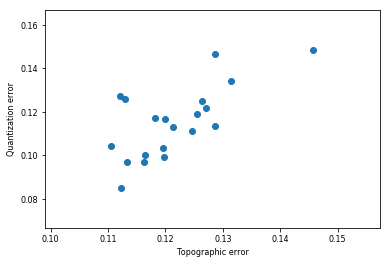

In [106]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

### From Original SOMtoolbox documentation
* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

In [ ]:
res = []
for i, model_filepath in enumerate(models_pool):
    res.append({'model': model_filepath[2:10].strip('.'), 'topographical_error': e_top[i], 'quantization_error': e_q[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

results_df = pd.DataFrame(res)
#results_df
#print(model_filepath,e_top[i],e_q[i])


In [125]:
results_df.sort_values(['topographical_error'], ascending=True)

,model,quantization_error,topographical_error
10,model_18,0.104079,0.110590
13,model_3,0.127295,0.112160
0,model_0,0.084953,0.112230
18,model_8,0.125678,0.113000
6,model_14,0.096661,0.113210
19,model_9,0.096909,0.116220
16,model_6,0.100293,0.116510
14,model_4,0.116901,0.118105
1,model_1,0.103400,0.119565
3,model_11,0.099114,0.119760


#### Model 18 has the lowest topographic error so we will use these hyperparameters moving forward

In [126]:
#top_model = joblib.load('C:\\Users\goyetc\\SOMPY\\5_model_test_11_23\\model_2.joblib')
top_model_n20_r20_f40_pca_rect = joblib.load('C:\\Users\goyetc\\SOMPY\\model_18.joblib')

In [130]:
top_model_n20_r20_f40_pca_rect.calculate_map_size('rect')

[42, 53]

In [131]:
top_model_n20_r20_f40_pca_rect.calculate_topographic_error()

0.11058999999999999

In [132]:
top_model_n20_r20_f40_pca_rect.calculate_quantization_error()

0.10407937405421959

## Tune Model 18 with additional epochs

In [181]:
random.choice(['pca','random'])

'pca'

In [191]:
for i in range(1): 
    #sm = sompy.SOMFactory().build(ss, 
     #                       mapsize=[42,53], 
      #                      normalization = 'var', initialization=random.choice(['pca','random']), 
       #                     component_names=names, lattice=random.choice(['rect','hexa'])) 
    
    sm = sompy.SOMFactory().build(ss, 
                                  mapsize=[42,53], 
                                  normalization = 'var', 
                                  initialization='pca', 
                                  component_names=names, lattice='rect')
    
    sm.train(n_job=1, 
             verbose='info', 
             train_rough_len=40, 
             train_finetune_len=80)
    
    joblib.dump(sm, "model_18_opt{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.279000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 40

 epoch: 1 ---> elapsed time:  10.238000, quantization error: 0.969460

 epoch: 2 ---> elapsed time:  10.183000, quantization error: 0.837499

 epoch: 3 ---> elapsed time:  10.934000, quantization error: 0.779439

 epoch: 4 ---> elapsed time:  11.432000, quantization error: 0.741991

 epoch: 5 ---> elapsed time:  10.608000, quantization error: 0.714898

 epoch: 6 ---> elapsed time:  11.443000, quantization error: 0.696005

 epoch: 7 ---> elapsed time:  10.974000, quantization error: 0.682160

 epoch: 8 ---> elapsed time:  11.989000, quantization error: 0.670291

 epoch: 9 ---> elapsed time:  12.095000, quantization error: 0.658764

 epoch: 10 ---> elapsed time:  11.074000, quantization error: 0.646522

 epoch: 11 ---> elapsed time:  10.917000, quantization error: 0.634758

 epoch: 12 ---> elapsed time:  10.737000, quantization error: 0.625254

 

 epoch: 72 ---> elapsed time:  12.727000, quantization error: 0.273835

 epoch: 73 ---> elapsed time:  10.900000, quantization error: 0.272935

 epoch: 74 ---> elapsed time:  11.116000, quantization error: 0.272032

 epoch: 75 ---> elapsed time:  12.445000, quantization error: 0.271134

 epoch: 76 ---> elapsed time:  13.093000, quantization error: 0.270226

 epoch: 77 ---> elapsed time:  9.160000, quantization error: 0.269331

 epoch: 78 ---> elapsed time:  8.860000, quantization error: 0.268425

 epoch: 79 ---> elapsed time:  8.662000, quantization error: 0.267525

 epoch: 80 ---> elapsed time:  8.720000, quantization error: 0.266635

 Final quantization error: 0.266635
 train took: 1328.070000 seconds


In [193]:
#top_model = joblib.load('C:\\Users\goyetc\\SOMPY\\5_model_test_11_23\\model_2.joblib')
m18_ft = joblib.load('C:\\Users\goyetc\\SOMPY\\model_18_opt0.joblib')

In [194]:
m18_ft.calculate_map_size('rect')

[42, 53]

In [195]:
top_model_n20_r20_f40_pca_rect.calculate_topographic_error()

0.11058999999999999

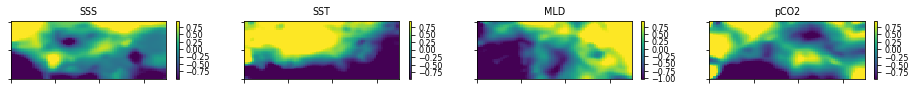

In [152]:
#top_model_n20_r20_f40_pca_rect.component_names = ['SSS','SST','MLD','pCO2']
from sompy.visualization.mapview import View2D
v2D = View2D(42,53, 'Model_18',text_size=8)  
v2D.show(top_model_n20_r20_f40_pca_rect, col_sz=4, denormalize=True) #which_dim='all' default

## Fine tuned model 18 is consistent with prior approach, per 2D projections of individual driver far
* performance did not increase significantly
* need to verify initial and final radiuses used are the same, may have been adjusted automatically by model
* would have expected further reduction in topographical error, but did not converge past prior val 0.110589999...

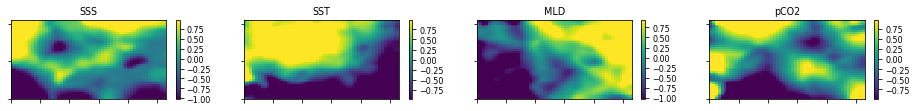

In [196]:
#top_model_n20_r20_f40_pca_rect.component_names = ['SSS','SST','MLD','pCO2']
from sompy.visualization.mapview import View2D
v2D = View2D(42,53, 'm18_ft',text_size=8)  
v2D.show(m18_ft, col_sz=4, denormalize=True) #which_dim='all' default

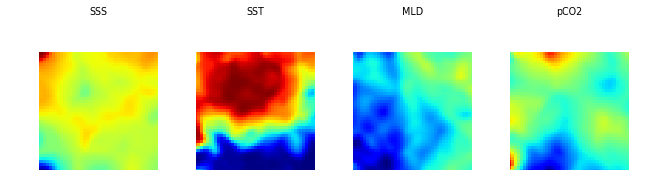

In [198]:
m18_ft.component_names = ['SSS','SST','MLD','pCO2']
v = sompy.mapview.View2DPacked(10,10, '',text_size=8)  
v.show(m18_ft, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default

In [75]:
SOM_sample.head()

,time,ylat,xlon,SSS,MLD,SST,pCO2
0,1991-02-15 00:00:00,-69.5,262.5,33.063404,3.040116,0.912769,256.854261
1,2004-04-16 00:00:00,-14.5,351.5,36.528145,3.996969,24.984589,378.942254
2,1993-05-16 12:00:00,65.5,355.5,35.387138,3.503074,6.933974,259.338336
3,1985-12-16 12:00:00,13.5,314.5,36.124840,4.312739,24.658592,329.150366
4,2010-09-16 00:00:00,87.5,53.5,32.139183,3.256311,-1.789207,270.250258


In [76]:
results = top_model.find_k_nodes(ss, k=5)

In [77]:
results[0].shape

(200000L, 5L)

In [78]:
results[0][:5,:]

array([[ 0.20838558,  0.21659089,  0.33356933,  0.33375222,  0.33929604],
       [ 0.25186454,  0.29649064,  0.30960686,  0.31078823,  0.32385254],
       [ 0.68288001,  0.69301636,  0.71529327,  0.7525345 ,  0.80092035],
       [ 0.20073887,  0.25207227,  0.30090181,  0.32677858,  0.32766614],
       [ 0.38314933,  0.48289758,  0.48385238,  0.48941768,  0.49506794]])

In [70]:
results[1].shape

(200000L, 8L)

In [82]:
map_labels = top_model.cluster(n_clusters=5)
data_labels = np.array([map_labels[int(k)] for k in top_model._bmu[0]])

In [83]:
data_labels.shape

(200000L,)

## TO DO
* See v4, cleaned up and exported dataframe with 5, 10, and 15 cluster results on current SOM with n=200k and hyperparameters listed above

In [ ]:
map_labels_k5 = top_model_n20_r20_f40_pca_rect.cluster(n_clusters=5)
data_labels_k5 = np.array([map_labels_k5[int(k)] for k in top_model_n20_r20_f40_pca_rect._bmu[0]])

In [ ]:
map_labels_k10 = top_model_n20_r20_f40_pca_rect.cluster(n_clusters=10)
data_labels_k10 = np.array([map_labels_k10[int(k)] for k in top_model_n20_r20_f40_pca_rect._bmu[0]])

In [ ]:
map_labels_k15 = top_model_n20_r20_f40_pca_rect.cluster(n_clusters=15)
data_labels_k15 = np.array([map_labels_k15[int(k)] for k in top_model_n20_r20_f40_pca_rect._bmu[0]])

In [ ]:
SOM_sample['k=5'] = data_labels_k5
SOM_sample['k=10'] = data_labels_k10
SOM_sample['k=15'] = data_labels_k15

In [ ]:
SOM_sample.sample(100)

In [ ]:
SOM_sample.to_csv('C:\\Users\\goyetc\\ocean-co2-absorption\\notebooks\\SOM_output_200k.csv',
                  sep=',',
                  na_rep='NaN',
                  columns=[u'time', u'ylat', u'xlon',  u'SSS',  u'MLD',  u'SST', u'pCO2',  u'k=5',
       u'k=10', u'k=15'],
                  header=True,
                  index=True,
                  mode='w')
                  